#### Primero vamos a crear el contexto de Spark

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!apt-get install python3.7
#!pip install pyspark==2.3.0
!pip install pyspark==3.4.0
import urllib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True
from pyspark import SparkContext, SparkConf, rdd
sc = SparkContext("local", "IntrusionDetection")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=bfec7a34ffc33a78a39234a6aba3f4718f1f3156a74232f0b41e29c448756106
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


#### Cargamos los datasets de training y de test en RDDs

En esta ocasión trabajaremos con RDDs para ver la diferencia respecto a los spark dataframes, pero a nivel de distribución de carga de trabajo no hay diferencia

In [3]:
from pyspark import SparkFiles

train_file = "/content/drive/MyDrive/seguridadyprivacidad/kddcup.data.10000"
test_file = "/content/drive/MyDrive/seguridadyprivacidad/corrected.1000"

train_rdata = sc.textFile(train_file)
test_rdata = sc.textFile(test_file)

In [4]:
type(train_rdata)
type(test_rdata)

pyspark.rdd.RDD

In [5]:
# Veamos que pinta tienen esos datos
print(train_rdata.collect()[:3])

['0,icmp,ecr_i,SF,520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,smurf.', '0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,smurf.', '0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,smurf.']


Como podemos ver, ha metido el CSV como un string en cada posición del array...

También podemos ver que la forma de imprimir por pantalla el contenido de un RDD es 'peculiar'

#### Preparamos los datos en forma de (etiqueta, vector de features), filtrando las columnas cualitativas 1,2,3 junto a la etiqueta correspondiente

In [6]:
from pyspark.mllib.linalg import Vectors

# Definimos una función para preparar los datos. Esta función tomará como parámetro cada elemento del RDD, que ya
# sabemos que es un string separado por comas
def transformData(x):
    # Ya tenemos el String, ahora spliteamos por comas para tener cada feature en un elemento del array
    splittedFeatures = x.split(",")

    # Quitamos las columnas cualitativas, posición (1,2,3), en el volcado anterior tienen los valores
    # "icmp", "ecr_i" y "SF", y la etiqueta que la identifica como ataque / tipo de ataque (último elemento del array)
    # en el volcado anterior sería el valor "smurf"
    onlyNumericalFeatures = [1,2,3,len(splittedFeatures)-1]

    onlyNumericalFeaturesInFloat = []

    # Convertimos los datos de string a float
    for i in range(len(splittedFeatures)):
        if i not in onlyNumericalFeatures:
            onlyNumericalFeaturesInFloat.append(float(splittedFeatures[i]))

    # Los metemos dentro de un vector
    vector = Vectors.dense(onlyNumericalFeaturesInFloat)

    # Recogemos la etiqueta, que estaba en la última posición
    label = splittedFeatures[len(splittedFeatures)-1]

    # Lo devolvemos
    return (label, vector)

# Aplicamos la transformación custom que acabamos de implementar a todo el dataset
tr_treat = train_rdata.map(transformData)
print (tr_treat.count())

# Y también al de testing
ts_treat = test_rdata.map(transformData)
print (ts_treat.count())

10000
1000


quitar

In [7]:
tr_treat.take(1)

[('smurf.',
  DenseVector([0.0, 520.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 511.0, 511.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 255.0, 255.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]))]

Bien, como podemos observar, ya tenemos los datos como queríamos. Catalogados y transformados a float.

Ahora vamos a curiosear un poco en los datos, a ver cómo están repartidos

### Análisis de datos

In [8]:
import numpy as np
from numpy import array

# Obtenemos solo el vector (no pillamos la etiqueta)
tr_treat_01 = tr_treat.map(lambda x: x[1])

# Y aquí lo mismo, pero al revés. Nos quedamos solo con la etiqueta
ltr_treat_01 = tr_treat.map(lambda x: x[0])

# Vamos a contar cuántos tipos de errores tenemos
cuentasErroresRdd = ltr_treat_01.map(lambda l: (l,1)).reduceByKey(lambda a,b: a+b)
lcuentasErrores = cuentasErroresRdd.collect()

print(lcuentasErrores)

[('smurf.', 5665), ('neptune.', 2215), ('normal.', 2019), ('satan.', 26), ('ipsweep.', 28), ('back.', 9), ('portsweep.', 22), ('pod.', 2), ('nmap.', 8), ('warezclient.', 2), ('teardrop.', 4)]


In [9]:
dd = tr_treat.map(lambda x: (x[0], x[1])).countByKey()
print(dd)

defaultdict(<class 'int'>, {'smurf.': 5665, 'neptune.': 2215, 'normal.': 2019, 'satan.': 26, 'ipsweep.': 28, 'back.': 9, 'portsweep.': 22, 'pod.': 2, 'nmap.': 8, 'warezclient.': 2, 'teardrop.': 4})


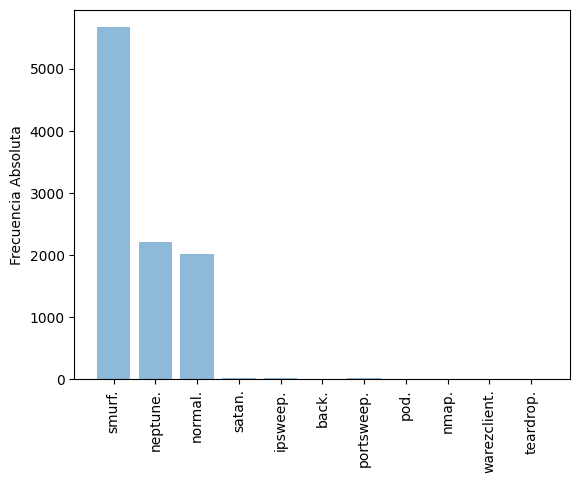

In [10]:
# Ahora lo dibujamos en una gráfica
labErrores = list(map(lambda x: x[0],lcuentasErrores))
y_pos = np.arange(len(labErrores))

valErrores = list(map(lambda x: x[1],lcuentasErrores))

plt.bar(y_pos, valErrores, align='center', alpha=0.5 )
plt.xticks(y_pos, list(labErrores), rotation=90)
plt.ylabel('Frecuencia Absoluta')
plt.show()

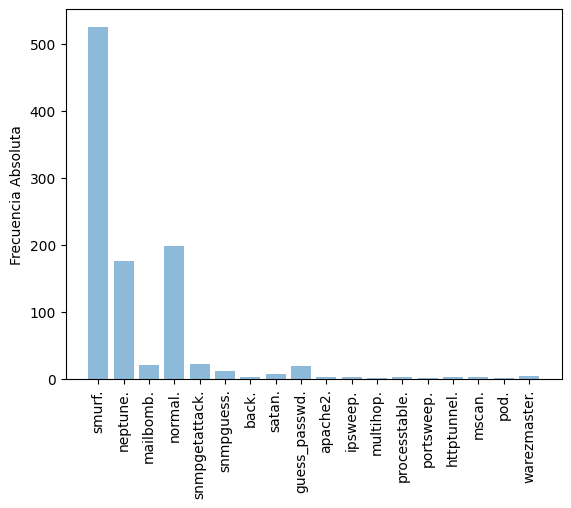

In [11]:
# Ahora repetimos lo mismo para el conjunto de datos de test
ts_treat_01 = ts_treat.map(lambda x: x[1])
lts_treat_01 = ts_treat.map(lambda x: x[0])

## Estadística descriptiva
cuentasErroresRdd = lts_treat_01.map(lambda l: (l,1)).reduceByKey(lambda a,b:a+b)
lcuentasErrores = cuentasErroresRdd.collect()
labErrores = list(map(lambda x: x[0],lcuentasErrores))
y_pos = np.arange(len(labErrores))
valErrores = list(map(lambda x: x[1],lcuentasErrores))

plt.bar(y_pos, valErrores, align='center', alpha=0.5 )
plt.xticks(y_pos, labErrores, rotation=90)
plt.ylabel('Frecuencia Absoluta')
plt.show()

Parece un pelín desbalanceado, quizá con más "pico y pala" podríamos mejorar eso. Hay algunos ataques del conjunto de datos de test que no aparecen en el conjunto de datos de entrenamiento, así que probablemente el accuracy no sea demasiado alto en este caso.

Antes de entrenar tenemos que preocuparnos de normalizar los datos. Como hemos podido ver en el dataset, hay valores que "chillan" más que otros

![image.png](attachment:image.png)

Tenemos que normalizar las características. Veremos dos métodos.

### Normalización de características

In [12]:
# Method 1. Usando StandardScaler. Sencillo y para toda la familia
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
# Creamos sesion
spark = SparkSession.builder.getOrCreate()
# Pasamos a df
df_tr_treat = tr_treat_01.map(lambda line: (Vectors.dense(line),)).toDF(["vector"])
df_ts_treat = ts_treat_01.map(lambda line: (Vectors.dense(line),)).toDF(["vector"])
# Definimos el modelo de normalización de características
scaler = StandardScaler(inputCol="vector", outputCol="scaled_vector", withMean=True, withStd=True)
# Entrenamos el modelo
scaler_model = scaler.fit(df_tr_treat)
# Obtención de los datos
std_train_data = scaler_model.transform(df_tr_treat).select("scaled_vector")
std_test_data = scaler_model.transform(df_ts_treat).select("scaled_vector")
# Rellenar aquí
print ("Train:",std_train_data.take(1))
print ("Test:", std_test_data.take(1))

Train: [Row(scaled_vector=DenseVector([-0.0744, -0.0803, -0.0898, 0.0, -0.0227, 0.0, -0.0323, 0.0, -0.4118, -0.0316, 0.0, 0.0, -0.0251, -0.0163, -0.0141, -0.0361, 0.0, 0.0, -0.0361, 0.8429, 0.8894, -0.4735, -0.4738, -0.2405, -0.241, 0.5435, -0.2646, -0.1984, 0.343, 0.6235, 0.6029, -0.2842, 0.8328, -0.1627, -0.474, -0.4734, -0.2436, -0.2432]))]
Test: [Row(scaled_vector=DenseVector([-0.0744, -0.0803, -0.0898, 0.0, -0.0227, 0.0, -0.0323, 0.0, -0.4118, -0.0316, 0.0, 0.0, -0.0251, -0.0163, -0.0141, -0.0361, 0.0, 0.0, -0.0361, 0.8429, 0.8894, -0.4735, -0.4738, -0.2405, -0.241, 0.5435, -0.2646, -0.1984, 0.343, 0.6235, 0.6029, -0.2842, 0.8328, -0.1627, -0.474, -0.4734, -0.2436, -0.2432]))]


In [13]:
'''from pyspark.sql import Row
str_treat_label = tr_treat.map(lambda line: Row(label=line[0]))
df_tr_treat_label = spark.createDataFrame(str_treat_label)
display(df_tr_treat_label.drop_duplicates().show())'''


'from pyspark.sql import Row\nstr_treat_label = tr_treat.map(lambda line: Row(label=line[0]))\ndf_tr_treat_label = spark.createDataFrame(str_treat_label)\ndisplay(df_tr_treat_label.drop_duplicates().show())'

In [14]:
# Method 2. Usando nuestra propia función (la que hay en los apuntes)

# Esto es más artesanal, pero sabes lo que haces ;)
def escala(media, desviacion):
    def _escala(vector):
        epsilon = 0.000000001
        vectR = (vector - media)/(desviacion + epsilon)
        return vectR
    return _escala

media = tr_treat_01.mean()
desv = tr_treat_01.stdev()
std_train_data2 = tr_treat_01.map(escala(media,desv))
std_test_data2 = ts_treat_01.map(escala(media,desv))

print ("Train:", std_train_data2.take(1))
print ("Test:", std_test_data2.take(1))

Train: [DenseVector([-0.0744, -0.0803, -0.0898, 0.0, -0.0227, 0.0, -0.0323, 0.0, -0.4118, -0.0316, 0.0, 0.0, -0.0251, -0.0163, -0.0141, -0.0361, 0.0, 0.0, -0.0361, 0.843, 0.8894, -0.4736, -0.4738, -0.2405, -0.241, 0.5436, -0.2646, -0.1984, 0.343, 0.6235, 0.603, -0.2842, 0.8329, -0.1627, -0.474, -0.4734, -0.2436, -0.2432])]
Test: [DenseVector([-0.0744, -0.0803, -0.0898, 0.0, -0.0227, 0.0, -0.0323, 0.0, -0.4118, -0.0316, 0.0, 0.0, -0.0251, -0.0163, -0.0141, -0.0361, 0.0, 0.0, -0.0361, 0.843, 0.8894, -0.4736, -0.4738, -0.2405, -0.241, 0.5436, -0.2646, -0.1984, 0.343, 0.6235, 0.603, -0.2842, 0.8329, -0.1627, -0.474, -0.4734, -0.2436, -0.2432])]


**Son las mismas**. Moraleja, usad StandardScaler

In [15]:
# Preparamos las etiquetas. Como es un modelo binomial, solo tendremos dos variables 0 y 1
# 0 será que no hay ataque y 1 será que si que hay ataque
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import DenseVector
train_rdata_std = ltr_treat_01.zip(std_train_data.select("scaled_vector").rdd)
test_rdata_std = lts_treat_01.zip(std_test_data.select("scaled_vector").rdd)
def prepDatosClasBinario(x):
    label = x[0]
    v_datos = x[1]

    ataque = 1
    if (label.find('normal') >=0 ):
        ataque = 0

    vector = DenseVector(v_datos).values

    return LabeledPoint(ataque, vector)

train_data = train_rdata_std.map(lambda x: [x[0],x[1]]).map(prepDatosClasBinario)
test_data = test_rdata_std.map(lambda x: [x[0],x[1]]).map(prepDatosClasBinario)

print("Train: ",train_data.take(2))
print("Test: ",test_data.take(2))

Train:  [LabeledPoint(1.0, [-0.07439697636174623,-0.08032717874163063,-0.08981680428706246,0.0,-0.02271572240082217,0.0,-0.03230059675814934,0.0,-0.4117932542071644,-0.031637017888873485,0.0,0.0,-0.025123220519887732,-0.016331292752446887,-0.014142842854277925,-0.036077167719207555,0.0,0.0,-0.036077167719207555,0.842929005315917,0.8893621649633467,-0.47353956361513533,-0.4738069286062516,-0.2404806543482855,-0.24097813272761465,0.5435477979783391,-0.26456089458696075,-0.19843574776607154,0.3430282463382891,0.6234941516320116,0.6029485998237842,-0.2841959954406004,0.8328402678504768,-0.16273494498443217,-0.4739563685518049,-0.47337084329519136,-0.24357865324647887,-0.24322131073369385]), LabeledPoint(1.0, [-0.07439697636174623,0.15309922912777946,-0.08981680428706246,0.0,-0.02271572240082217,0.0,-0.03230059675814934,0.0,-0.4117932542071644,-0.031637017888873485,0.0,0.0,-0.025123220519887732,-0.016331292752446887,-0.014142842854277925,-0.036077167719207555,0.0,0.0,-0.036077167719207555,0

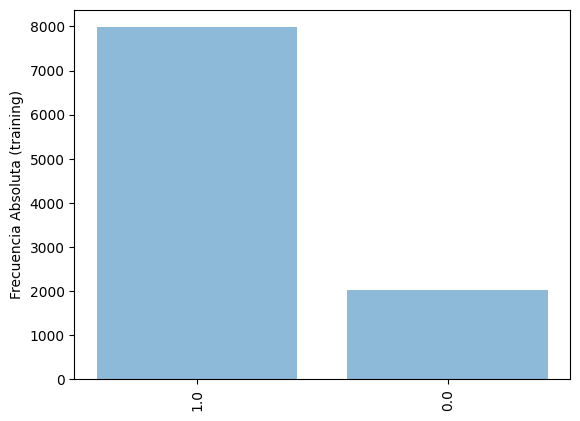

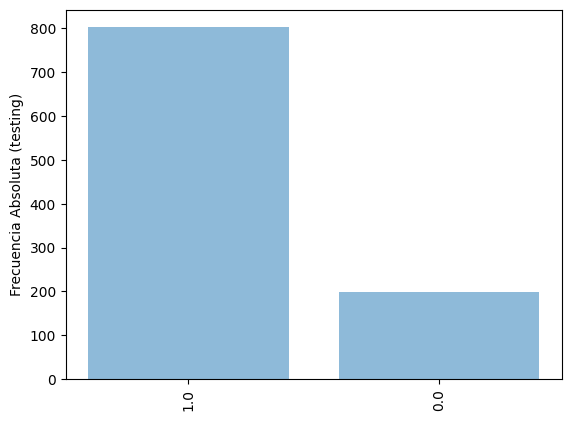

In [16]:
# Vamos a ver que pinta tiene
tr_treat_01 = train_data.map(lambda p: p.features)
ltr_treat_01 = train_data.map(lambda p: p.label)

# Estadística descriptiva
cuentasErroresRdd = ltr_treat_01.map(lambda l: (l,1)).reduceByKey(lambda a,b:a+b)
lcuentasErrores=cuentasErroresRdd.collect()
labErrores=list(map(lambda x:x[0],lcuentasErrores))

y_pos = np.arange(len(labErrores))
valErrores=list(map(lambda x:x[1],lcuentasErrores))
plt.bar(y_pos, valErrores, align='center', alpha=0.5 )
plt.xticks(y_pos, labErrores, rotation=90)
plt.ylabel('Frecuencia Absoluta (training)')
plt.show()

ts_treat_01 = test_data.map(lambda p: p.feautes)
lts_treat_01 = test_data.map(lambda p: p.label)

# Estadística descriptiva
cuentasErroresRdd=lts_treat_01.map(lambda l: (l,1)).reduceByKey(lambda a,b:a+b)
lcuentasErrores=cuentasErroresRdd.collect()
labErrores=list(map(lambda x:x[0],lcuentasErrores))
y_pos = np.arange(len(labErrores))
valErrores=list(map(lambda x:x[1],lcuentasErrores))
plt.bar(y_pos, valErrores, align='center', alpha=0.5 )
plt.xticks(y_pos, labErrores, rotation=90)
plt.ylabel('Frecuencia Absoluta (testing)')
plt.show()

Bueno, en números absolutos no está tan desbalanceado como parecía. Al agrupar todos los ataques en una sola categoría (1), ha quedado bastante bien

In [17]:
train_data.take(1)

[LabeledPoint(1.0, [-0.07439697636174623,-0.08032717874163063,-0.08981680428706246,0.0,-0.02271572240082217,0.0,-0.03230059675814934,0.0,-0.4117932542071644,-0.031637017888873485,0.0,0.0,-0.025123220519887732,-0.016331292752446887,-0.014142842854277925,-0.036077167719207555,0.0,0.0,-0.036077167719207555,0.842929005315917,0.8893621649633467,-0.47353956361513533,-0.4738069286062516,-0.2404806543482855,-0.24097813272761465,0.5435477979783391,-0.26456089458696075,-0.19843574776607154,0.3430282463382891,0.6234941516320116,0.6029485998237842,-0.2841959954406004,0.8328402678504768,-0.16273494498443217,-0.4739563685518049,-0.47337084329519136,-0.24357865324647887,-0.24322131073369385])]

In [18]:
test_data.take(1)

[LabeledPoint(1.0, [-0.07439697636174623,-0.08032717874163063,-0.08981680428706246,0.0,-0.02271572240082217,0.0,-0.03230059675814934,0.0,-0.4117932542071644,-0.031637017888873485,0.0,0.0,-0.025123220519887732,-0.016331292752446887,-0.014142842854277925,-0.036077167719207555,0.0,0.0,-0.036077167719207555,0.842929005315917,0.8893621649633467,-0.47353956361513533,-0.4738069286062516,-0.2404806543482855,-0.24097813272761465,0.5435477979783391,-0.26456089458696075,-0.19843574776607154,0.3430282463382891,0.6234941516320116,0.6029485998237842,-0.2841959954406004,0.8328402678504768,-0.16273494498443217,-0.4739563685518049,-0.47337084329519136,-0.24357865324647887,-0.24322131073369385])]

In [19]:
# Entrenamos el modelo
#!pip freeze | grep pyspark --> para ver version de pyspark
#!apt-get -qq install -y pyspark.mllib.classification --> Este es el que ha funcionado
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
lm = LogisticRegressionWithLBFGS.train(train_data, iterations=10)
# Intercept del modelo
print(lm.intercept)

# Pesos del modelo
print(lm.weights)

0.0
[-0.13520582561928965,0.34010591659877787,-1.02955831179824,0.0,0.8839216874848672,0.0,-0.24721604350021426,0.0,-4.626012245474581,1.1827529970687065,0.0,0.0,-0.18643955659355396,-0.19099022962295945,-0.16567738014832029,-0.42073598474469914,0.0,0.0,-0.41308620072460683,3.044876614400878,2.416895882537301,0.8147609707432417,0.8071586047486634,0.40814468708670115,0.41579791646074815,-1.302337870606114,-0.11765607001936187,0.321306046577948,2.7089559560179333,-1.3270528932356498,-1.1522617565715372,-0.26691228114838184,3.068082921106211,1.3893286692869646,0.8142786631172578,0.8133483693140964,0.29145013675437004,0.40555560785998196]


In [20]:
test_data.toDF().printSchema()
# Comprobamos el número total de registros en el test_data
num_records = test_data.count()
print("Número de registros en test_data:", num_records)
# Comprobamos las caracteristicas del primer registro del test_data
first_record = test_data.first()
num_features = len(first_record.features)
print("Número de características en el primer registro:", num_features)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

Número de registros en test_data: 1000
Número de características en el primer registro: 38


In [21]:
#Tratamos estos datos
from pyspark.sql import SparkSession

etiquetas = []
predicciones = []
test_records = test_data.collect()

for record in test_records:
    etiquetas.append(float(record.label))
    predicciones.append(float(lm.predict(record.features)))

# Creamos SparkSession
spark = SparkSession.builder.getOrCreate()
# Creamos DataFrame a partir de las listas de etiquetas y predicciones
df_test = spark.createDataFrame(zip(etiquetas, predicciones), ["etiqueta", "predicciones"])
# Visualizamos
df_test.show()
# Guardamos los datos en la misma variable que registran
etiq_y_pred = df_test.rdd

+--------+------------+
|etiqueta|predicciones|
+--------+------------+
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         0.0|
|     0.0|         0.0|
|     1.0|         0.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         0.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         1.0|
|     1.0|         0.0|
|     0.0|         0.0|
|     0.0|         0.0|
|     1.0|         1.0|
+--------+------------+
only showing top 20 rows



In [22]:
# Ahora vamos a ver como se comporta el modelo con los datos de test

# Para eso
#etiq_y_pred = test_data.map(lambda p: (p.label, lm.predict(p.features)))

def cuentasOKvsKO(v):
    vR = v[0]
    vP = v[1]

    resultado="OK"
    if (vR != vP):
        resultado="KO"

    return (resultado,1)

resultados = etiq_y_pred.map(cuentasOKvsKO).reduceByKey(lambda v1,v2: v1+v2).collect()

# Esta es una función que hizo un compañero, comprobar que calculaError da igual que 1-accuracy si utilizamos pyspark y sklearn
def calculaError(v):

    dRes={}
    dRes[v[0][0]]=v[0][1]
    dRes[v[1][0]]=v[1][1]

    error = float(dRes["KO"])*100/(float(dRes["OK"])+float(dRes["KO"]))

    return error

error = calculaError(resultados)
print ("Error: {}%".format(round(error,2)))

Error: 19.1%


In [23]:
#etiq_y_pred.collect()
y_true = etiq_y_pred.map(lambda x: x[0]).collect()
y_pred = etiq_y_pred.map(lambda x: x[1]).collect()

In [24]:
print(type(y_true))
print(type(y_pred))

<class 'list'>
<class 'list'>


In [25]:
import sklearn
from sklearn.metrics import accuracy_score

# RELLENAR AQUÍ => utilizar y_true y_pred
#Comprobación del error con sklearn.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
error2 = 1 - accuracy
print("Error: {}%".format(round(error2*100,2)))

Error: 19.1%


# Empezar aquí ejercicio clasificación multiclase

In [26]:
# Obtenemos solo el vector (no pillamos la etiqueta)
tr_treat_02 = tr_treat.map(lambda x: x[1])
# Y aquí lo mismo, pero al revés. Nos quedamos solo con la etiqueta
ltr_treat_02 = tr_treat.map(lambda x: x[0])
# Hacemos los mismo para el test
ts_treat_02 = ts_treat.map(lambda x: x[1])
lts_treat_02 = ts_treat.map(lambda x: x[0])

In [27]:
#Codificación de variables categoricas --> PARTE DE ETIQUETAS
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Convertimos el RDD a un DataFrame
df_ltr = ltr_treat_02.map(lambda x: (x,)).toDF(["etiqueta"])
df_lts = lts_treat_02.map(lambda x: (x,)).toDF(["etiqueta"])
# Aplicamos la codificación de etiquetas
indexer = StringIndexer(inputCol="etiqueta", outputCol="etiqueta_numerica")
df_encoded_ltr = indexer.fit(df_ltr).transform(df_ltr)
df_encoded_lts = indexer.fit(df_lts).transform(df_lts)
# Vemos el resultado y los pasamos a rdd (para luego poder hacer un zip)
ltr_treat_02_encoded = df_encoded_ltr.select("etiqueta_numerica").rdd.map(lambda row: row.etiqueta_numerica)
lts_treat_02_encoded = df_encoded_lts.select("etiqueta_numerica").rdd.map(lambda row: row.etiqueta_numerica)
#Almacenamos los resultados por darles un vistazo.
resultado_ltr = ltr_treat_02_encoded.take(15)
resultado_lts = lts_treat_02_encoded.take(15)
'''Mostramos los resultados para saber como ha sido la codificación smurf = 0, neptune = 1, normal = 2, snmpgetattack = 3
mailbomb = 4'''
for numero in resultado_ltr:
    print(numero)
ltr_treat_02.take(15)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
2.0
1.0
0.0
2.0


['smurf.',
 'smurf.',
 'smurf.',
 'smurf.',
 'smurf.',
 'smurf.',
 'smurf.',
 'neptune.',
 'smurf.',
 'neptune.',
 'smurf.',
 'normal.',
 'neptune.',
 'smurf.',
 'normal.']

In [28]:
#Vemos los del Test
for numero in resultado_lts:
    print(numero)
lts_treat_02.take(15)

0.0
0.0
2.0
4.0
1.0
0.0
2.0
0.0
2.0
0.0
3.0
2.0
0.0
0.0
0.0


['smurf.',
 'smurf.',
 'neptune.',
 'mailbomb.',
 'normal.',
 'smurf.',
 'neptune.',
 'smurf.',
 'neptune.',
 'smurf.',
 'snmpgetattack.',
 'neptune.',
 'smurf.',
 'smurf.',
 'smurf.']

In [29]:
#Contamos los valores que tenemos en el train de los posibles tipos de ataques.
ltr_treat_02_encoded.count()

10000

In [30]:
#Contamos los valores que tenemos en el test de los posibles tipos de ataques.
lts_treat_02_encoded.count()

1000

In [31]:
# Method 1. Usando StandardScaler. Sencillo y para toda la familia --> PARTE DE LOS VALORES POR DESVIACION TIPICA EN VECTOR.
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
# Creamos sesion
spark = SparkSession.builder.getOrCreate()
# Pasamos a df
df_tr_treat2 = tr_treat_02.map(lambda line: ((line),)).toDF(["features"])
df_ts_treat2 = ts_treat_02.map(lambda line: ((line),)).toDF(["features"])
assembler = VectorAssembler(inputCols=["features"],outputCol="features2")
assembled = assembler.transform(df_tr_treat2)
# Definimos el modelo de normalización de características
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
# Entrenamos el modelo
scaler_model2 = scaler.fit(assembled)
# Obtención de los datos
std_train_data2 = scaler_model2.transform(df_tr_treat2)
std_test_data2 = scaler_model2.transform(df_ts_treat2)
# Conversión en rdd para posteriomente juntarlos con el metodo zip
std_train_data3 = std_train_data2.rdd
std_test_data3 = std_test_data2.rdd
#Contamos los valores de std_train
std_train_data3.count()

10000

In [32]:
#Y de std_test:
std_test_data3.count()

1000

In [33]:
#Union de rdds
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import DenseVector
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors, VectorUDT

train_rdata_std2 = ltr_treat_02_encoded.zip(std_train_data3)
test_rdata_std2 = lts_treat_02_encoded.zip(std_test_data3)

In [34]:
train_rdata_std2.take(1)

[(0.0,
  Row(features=DenseVector([0.0, 520.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 511.0, 511.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 255.0, 255.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), scaledFeatures=DenseVector([-0.0744, -0.0803, -0.0898, 0.0, -0.0227, 0.0, -0.0323, 0.0, -0.4118, -0.0316, 0.0, 0.0, -0.0251, -0.0163, -0.0141, -0.0361, 0.0, 0.0, -0.0361, 0.8429, 0.8894, -0.4735, -0.4738, -0.2405, -0.241, 0.5435, -0.2646, -0.1984, 0.343, 0.6235, 0.6029, -0.2842, 0.8328, -0.1627, -0.474, -0.4734, -0.2436, -0.2432])))]

In [35]:
test_rdata_std2.take(1)

[(0.0,
  Row(features=DenseVector([0.0, 520.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 511.0, 511.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 255.0, 255.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]), scaledFeatures=DenseVector([-0.0744, -0.0803, -0.0898, 0.0, -0.0227, 0.0, -0.0323, 0.0, -0.4118, -0.0316, 0.0, 0.0, -0.0251, -0.0163, -0.0141, -0.0361, 0.0, 0.0, -0.0361, 0.8429, 0.8894, -0.4735, -0.4738, -0.2405, -0.241, 0.5435, -0.2646, -0.1984, 0.343, 0.6235, 0.6029, -0.2842, 0.8328, -0.1627, -0.474, -0.4734, -0.2436, -0.2432])))]

In [36]:
#Visualizamos el Dataframe de Train
'''data = train_rdata_std2.map(lambda x: (x[0], x[1].asDict())).collect()
df_train = spark.createDataFrame(data, schema=["label", "features"])
df_train.show(15)'''
data = train_rdata_std2.map(lambda x: (x[0], x[1]['features'])).collect()
df_train = spark.createDataFrame(data, schema=["label", "features"])
df_train.show(15)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,520.0,0.0,0....|
|  0.0|[0.0,1032.0,0.0,0...|
|  0.0|[0.0,1032.0,0.0,0...|
|  0.0|[0.0,1032.0,0.0,0...|
|  0.0|[0.0,1032.0,0.0,0...|
|  0.0|[0.0,1032.0,0.0,0...|
|  0.0|[0.0,1032.0,0.0,0...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1032.0,0.0,0...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1032.0,0.0,0...|
|  2.0|[0.0,43.0,127.0,0...|
|  1.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,520.0,0.0,0....|
|  2.0|[0.0,351.0,961.0,...|
+-----+--------------------+
only showing top 15 rows



In [37]:
#Como no llegamos a ver los valores los mostramos haciendo esto:
df_selected = df_train.select("features")
features_list = df_selected.rdd.map(lambda row: row.features).take(15)

# Mostrar los datos
for features in features_list:
    print(features)

[0.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511.0,511.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,255.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511.0,511.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,255.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511.0,511.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,255.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511.0,511.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,255.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511.0,511.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,255.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,511.0,511.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255.0,255.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]
[0.0,1032.0

In [38]:
#Y ademas vemos la estructura
df_train.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [39]:
#Vemos el tamaño de train
df_train.count()

10000

In [40]:
df_train22, df_test22 = df_train.randomSplit([0.8, 0.2], seed=42)

In [41]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
model = rf.fit(df_train22)

In [42]:
# Testeamos el modelo con los datos de testing
predictions = model.transform(df_test22)

In [54]:
# Y mostramos las primeras 5 predicciones
predictions.select("prediction", "label").tail(15)

[Row(prediction=4.0, label=4.0),
 Row(prediction=4.0, label=4.0),
 Row(prediction=4.0, label=4.0),
 Row(prediction=4.0, label=4.0),
 Row(prediction=2.0, label=4.0),
 Row(prediction=2.0, label=4.0),
 Row(prediction=2.0, label=4.0),
 Row(prediction=2.0, label=5.0),
 Row(prediction=5.0, label=5.0),
 Row(prediction=5.0, label=5.0),
 Row(prediction=6.0, label=6.0),
 Row(prediction=6.0, label=6.0),
 Row(prediction=6.0, label=6.0),
 Row(prediction=1.0, label=7.0),
 Row(prediction=2.0, label=9.0)]

In [44]:
# Evaluemos ahora la calidad del modelo. Para eso podemos usar un Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.00312337
Accuracy = 0.996877 


In [45]:
#Visualizamos el Dataframe de Test
'''data = train_rdata_std2.map(lambda x: (x[0], x[1].asDict())).collect()
df_train = spark.createDataFrame(data, schema=["label", "features"])
df_train.show(15)'''
data_test = test_rdata_std2.map(lambda x: (x[0], x[1]['features'])).collect()
df_test = spark.createDataFrame(data_test, schema=["label", "features"])
df_test.show(15)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,520.0,0.0,0....|
|  0.0|[0.0,1032.0,0.0,0...|
|  2.0|[0.0,0.0,0.0,0.0,...|
|  4.0|[1.0,2599.0,293.0...|
|  1.0|[0.0,157.0,7082.0...|
|  0.0|[0.0,1032.0,0.0,0...|
|  2.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,1032.0,0.0,0...|
|  2.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,520.0,0.0,0....|
|  3.0|[0.0,105.0,147.0,...|
|  2.0|[0.0,0.0,0.0,0.0,...|
|  0.0|[0.0,520.0,0.0,0....|
|  0.0|[0.0,1032.0,0.0,0...|
|  0.0|[0.0,1032.0,0.0,0...|
+-----+--------------------+
only showing top 15 rows



Entrenamiento del modelo con todo el train y evaluación

In [46]:
#Entrenamos con todo el train
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=500)
model = rf.fit(df_train)

In [47]:
# Testeamos el modelo con los datos de testing
predictions_fin = model.transform(df_test)

In [48]:
# Y mostramos las primeras 5 predicciones
predictions_fin.select("prediction", "label").show(15)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  2.0|
|       2.0|  4.0|
|       2.0|  1.0|
|       0.0|  0.0|
|       1.0|  2.0|
|       0.0|  0.0|
|       1.0|  2.0|
|       0.0|  0.0|
|       2.0|  3.0|
|       1.0|  2.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 15 rows



In [49]:
# Evaluemos ahora la calidad del modelo. Para eso podemos usar un Evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_fin = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="accuracy")
accuracy_fin = evaluator.evaluate(predictions_fin)

print("Test Error = %g" % (1.0 - accuracy_fin))
print("Accuracy = %g " % accuracy_fin)
error2 = 1 - accuracy_fin

Test Error = 0.475
Accuracy = 0.525 


In [50]:
import sklearn
from sklearn.metrics import accuracy_score
#Comprobación del error con sklearn.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions_fin.select("label").collect(), predictions_fin.select("prediction").collect())
error2 = 1 - accuracy
print("Error: {}%".format(round(error2*100,2)))

Error: 47.5%


Conclusión: los datos al estar tan desbalanceados por categorias de ataques, solo es capaz de predecir bien los ataques smurf, parece logico ya que son los que más datos tenemos en el train. Los otros tendriamos que recabar más datos para poder ver si el modelo entrena mejor o aplicar otras tecnicas de predicción.

Mejoras: Podriamos hacer en la parte del preproceso un inframuestreo, es decir, hacer un balanceo de la variable target (ataques) eliminando  ataques smurf o crear valores sintenticos de los otros de ataques para poder entrenar mejor nuestro modelo para mejorar las predicciones.

# Empezar aquí GridSearch